In [ ]:
import numpy as np
import matplotlib.pyplot as plt

##**System Forward Kinematics**: 

Recall the kinematics of diff drive system:

\begin{equation} 
\begin{bmatrix}
x_t \\ 
y_t \\ 
\gamma_t
\end{bmatrix} 
= 
\begin{bmatrix}
x_{t-1} + v_{t-1}\cos\gamma_{t-1}dt\\ 
y_{t-1} + v_{t-1}\sin\gamma_{t-1}dt\\ 
\gamma_{t-1} + \omega_{t-1} dt
\end{bmatrix} 
\end{equation}

Then the state space model is as follows:
\begin{equation} 
\begin{bmatrix}
x_t \\ 
y_t \\ 
\gamma_t
\end{bmatrix} 
=
\begin{bmatrix}
1 & 0 & 0\\
0 & 1 & 0\\
0 & 0 & 1
\end{bmatrix} 
\begin{bmatrix}
x_{t-1} \\ 
y_{t-1} \\ 
\theta_{t-1} 
\end{bmatrix}
+ 
\begin{bmatrix}
\cos\gamma_{t-1}dt & 0\\ 
\sin\gamma_{t-1}dt & 0\\ 
0 & dt
\end{bmatrix} 
\begin{bmatrix}
v_{t-1} \\ 
\omega_{t-1} 
\end{bmatrix} 
\end{equation}

which corresponds to 
\begin{equation} 
x_t  = A_{t-1}x_{t-1} + B_{t-1}u_{t-1} 
\end{equation}

where 
- $x_t$ is the current state vector at time t in the global coordinate frame.
- $x_{t-1}$ is the state vector at time t-1 in the global coordinate frame.
- $u_{t-1}$ represents the control input vector at time t-1.
- A and B are the state transition matrices.

We want to choose control inputs $u_{t-1}$ such that

1- $x_t$ actual – $x_t$ desired is small i.e. we get good control.

2- $u_{t-1}$ is small i.e. we use a minimal amount of actuator effort (i.e. control input, motor, etc.).

Both of these are competing objectives. A large u can drive the state error down really fast. A small u means the state error will remain really large. LQR was designed to solve this problem.

We let dt = 1 second. dt represents the interval between timesteps.

In [ ]:
# Supress scientific notation when printing NumPy arrays
np.set_printoptions(precision=3,suppress=True)
# Optional Variables
max_linear_velocity = 3.0 # meters per second
max_angular_velocity = 1.5708 # radians per second

In [ ]:
def getB(yaw, deltat):
  """
  Calculates and returns the B matrix 3x2 matix ---> number of states x number of control inputs
 
  Expresses how the state of the system [x,y,yaw] changes from t-1 to t due to the control commands (i.e. control inputs).
     
  :param yaw: The yaw angle (rotation angle around the z axis) in radians 
  :param deltat: The change in time from timestep t-1 to t in seconds
     
  :return: B matrix ---> 3x2 NumPy array
  """
  B = np.array([[np.cos(yaw)*deltat, 0],
                [np.sin(yaw)*deltat, 0],
                [0, deltat]])
  return B

In [ ]:
def state_space_model(A, state_t_minus_1, B, control_input_t_minus_1):
  """
  Calculates the state at time t given the state at time t-1 and the control inputs applied at time t-1
 
  :param A: The A state transition matrix 3x3 NumPy Array
  :param state_t_minus_1: The state at time t-1 3x1 NumPy Array given the state is [x,y,yaw angle] ---> [meters, meters, radians]
  :param B: The B state transition matrix 3x2 NumPy Array
  :param control_input_t_minus_1: Optimal control inputs at time t-1 2x1 NumPy Array given the control input vector is [linear velocity of the car (m/s), angular velocity of the car (rad/s)]
         
  :return State estimate at time t: 3x1 NumPy Array given the state is [x,y,yaw angle] ---> [meters, meters, radians]
  """

  # These next lines of code which place limits on the angular and linear velocities of the robot car can be removed if you desire.
  control_input_t_minus_1[0] = np.clip(control_input_t_minus_1[0], -max_linear_velocity, max_linear_velocity)
  control_input_t_minus_1[1] = np.clip(control_input_t_minus_1[1], -max_angular_velocity, max_angular_velocity)

  state_estimate_t = (A @ state_t_minus_1) + (B @ control_input_t_minus_1)

  return state_estimate_t

In [ ]:
def lqr(actual_state_x, desired_state_xf, Q, R, A, B):
  """
  Discrete-time linear quadratic regulator for a nonlinear system.
  Compute the optimal control inputs given a nonlinear system, cost matrices, current state, and a final state.
     
  Compute the control variables that minimize the cumulative cost.
 
  Solve for P using the dynamic programming method.
 
  :param actual_state_x: The current state of the system 3x1 NumPy Array given the state is [x,y,yaw angle] ---> [meters, meters, radians]
  :param desired_state_xf: The desired state of the system 3x1 NumPy Array given the state is [x,y,yaw angle] ---> [meters, meters, radians]   
  :param Q: The state cost matrix 3x3 NumPy Array
  :param R: The input cost matrix 2x2 NumPy Array
  :param dt: The size of the timestep in seconds -> float
 
  :return u_star: Optimal action u for the current state  2x1 NumPy Array given the control input vector is [linear velocity of the car (m/s), angular velocity of the car (rad/s)]
  """

  # We want the system to stabilize at desired_state_xf.
  x_error = actual_state_x - desired_state_xf
  
  # Solutions to discrete LQR problems are obtained using the dynamic programming method.
  # The optimal solution is obtained recursively, starting at the last timestep and working backwards.
  # You can play with this number
  N = 50
  # Create a list of N + 1 elements
  P = [None] * (N + 1)
  Qf = Q
  
  # LQR via Dynamic Programming
  P[N] = Qf
  
  # For i = N, ..., 1
  for i in range(N, 0, -1):
    # Discrete-time Algebraic Riccati equation to calculate the optimal state cost matrix
    P[i-1] = Q + A.T @ P[i] @ A - (A.T @ P[i] @ B) @ np.linalg.pinv(R + B.T @ P[i] @ B) @ (B.T @ P[i] @ A)      
    
  # Create a list of N elements
  K = [None] * N
  u = [None] * N
    
  # For i = 0, ..., N - 1
  for i in range(N):
    # Calculate the optimal feedback gain K
    K[i] = -np.linalg.pinv(R + B.T @ P[i+1] @ B) @ B.T @ P[i+1] @ A
    u[i] = K[i] @ x_error
  
  # Optimal control input is u_star
  u_star = u[N-1]
  
  return u_star

In [ ]:
# Let the time interval be 1.0 seconds
t0 = t = 0
dt = 1

# Actual state
# Our robot starts out at the origin (x=0 meters, y=0 meters), and the yaw angle is 0 radians. 
actual_state_x = np.array([0,0,0])

# Desired state [x,y,yaw angle] ---> [meters, meters, radians]
desired_state_xf = np.array([2.000,2.000,np.pi/2])  

# A matrix (sometimes F in the literature) 3x3 matrix -> number of states x number of states matrix
# Expresses how the state of the system [x,y,yaw] changes from t-1 to t when no control command is executed.
# For this case, A is the identity matrix.
A = np.eye(3)

# R matrix: The control input cost matrix
# This matrix penalizes actuator effort (i.e. rotation of the motors on the wheels that drive the linear velocity and angular velocity).
# We can target control inputs where we want low actuator effort by making the corresponding value of R large. 
R = np.array([[0.01, 0],  # Penalty for linear velocity effort
              [0, 0.01]]) # Penalty for angular velocity effort

# Q matrix: The state cost matrix.
# Q helps us weigh the relative importance of each state in the state vector (X, Y, YAW ANGLE). 
# Q penalizes bad performance. It enables us to target states where we want low error by making the corresponding value of Q large.
Q = np.array([[0.639, 0, 0], # Penalize X position error
              [0, 1.0, 0],   # Penalize Y position error 
              [0, 0, 1.0]])  # Penalize YAW ANGLE heading error 

Actual_State_X = actual_state_x
# Launch the robot, and have it move to the desired goal destination
for i in range(100):
  print(f'iteration = {i} seconds')
  print(f'Current State = {actual_state_x}')
  print(f'Desired State = {desired_state_xf}')
  
  state_error = actual_state_x - desired_state_xf
  state_error_magnitude = np.linalg.norm(state_error)
  print(f'State Error Magnitude = {state_error_magnitude}')

  B = getB(actual_state_x[2], dt)

  # LQR returns the optimal control input
  optimal_control_input = lqr(actual_state_x, desired_state_xf, Q, R, A, B) 
  print(f'Control Input = {optimal_control_input}')

  # We apply the optimal control to the robot so we can get a new actual (estimated) state.
  actual_state_x = state_space_model(A, actual_state_x, B, optimal_control_input)  
  Actual_State_X = np.vstack([Actual_State_X, actual_state_x])
  t = t+dt
  # Stop as soon as we reach the goal
  # Feel free to change this threshold value.
  if state_error_magnitude < 0.01:
    print("\nGoal Has Been Reached Successfully!")
    break
  
  print()

iteration = 0 seconds
Current State = [0 0 0]
Desired State = [2.    2.    1.571]
State Error Magnitude = 3.2353363194994644
Control Input = [1.969 1.555]

iteration = 1 seconds
Current State = [1.969 0.    1.555]
Desired State = [2.    2.    1.571]
State Error Magnitude = 2.0002978637484863
Control Input = [1.98  0.015]

iteration = 2 seconds
Current State = [2.    1.98  1.571]
Desired State = [2.    2.    1.571]
State Error Magnitude = 0.019807158896646308
Control Input = [0.02 0.  ]

iteration = 3 seconds
Current State = [2.    2.    1.571]
Desired State = [2.    2.    1.571]
State Error Magnitude = 0.00019662973052900144
Control Input = [0. 0.]

Goal Has Been Reached Successfully!


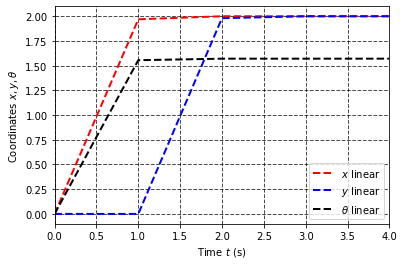

In [ ]:
x_l, y_l, theta_l = Actual_State_X[:,0], Actual_State_X[:,1], Actual_State_X[:,2] 
t_span = np.linspace(t0, t, Actual_State_X.shape[0])
# Plot the resulst
plt.plot(t_span, x_l, 'r--', linewidth=2.0, label = r'$x$')
plt.plot(t_span, y_l, 'b--', linewidth=2.0, label = r'$y$')
plt.plot(t_span, theta_l, 'k--', linewidth=2.0, label = r'$\theta$')
plt.grid(color='black', linestyle='--', linewidth=1.0, alpha = 0.7)
plt.grid(True)
plt.legend()
plt.xlim([t0, t])
plt.ylabel(r'Coordinates $x,y,\theta$')
plt.xlabel(r'Time $t$ (s)')
plt.show()